In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import cv2

In [2]:
X_train = np.load('Dataset/data_train.npy')
t_train = np.load('Dataset/labels_train_corrected.npy')

X_train = X_train.T

X_train.shape, t_train.shape

((6720, 90000), (6720,))

In [3]:
# Reshape the training data set
X_train_reshaped = np.zeros((6720, 2500))

for i in range(len(X_train[:, 0])):
    im1 = X_train[i, :].reshape(300,300)
    res = cv2.resize(im1, dsize=(50, 50), interpolation=cv2.INTER_CUBIC)
    X_train_reshaped[i, :] = res.reshape(2500,)

X_train_reshaped.shape

(6720, 2500)

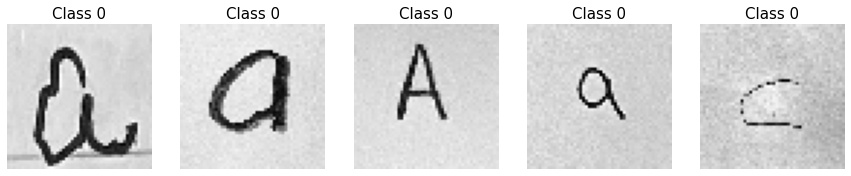

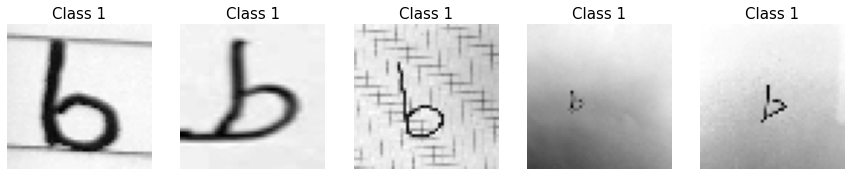

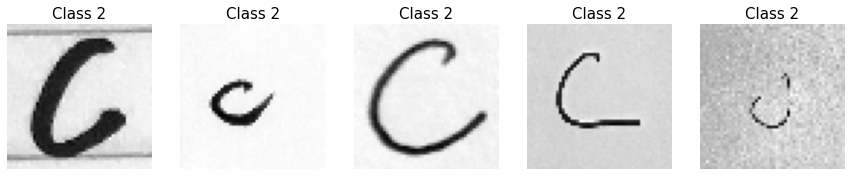

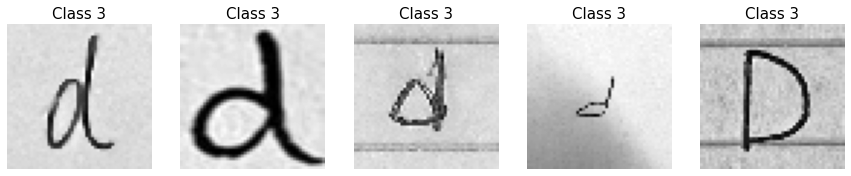

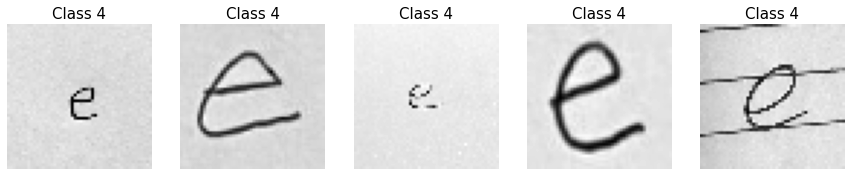

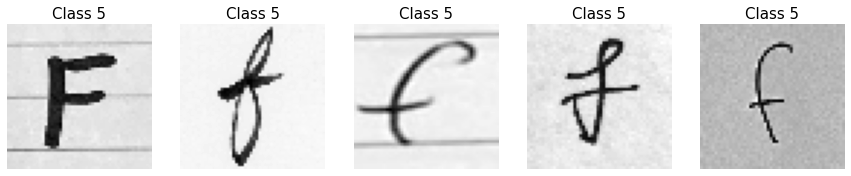

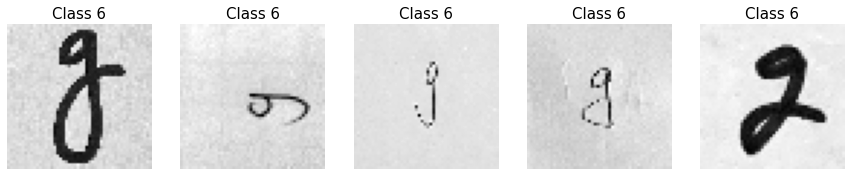

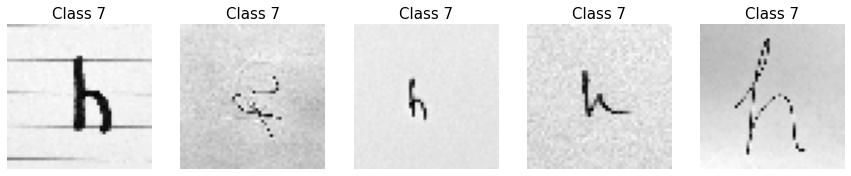

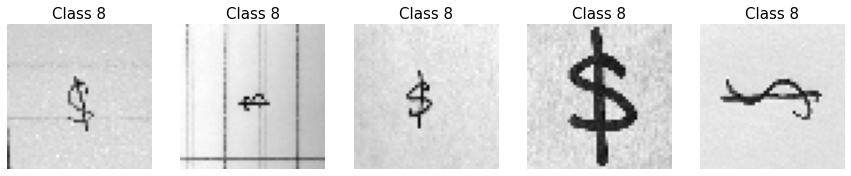

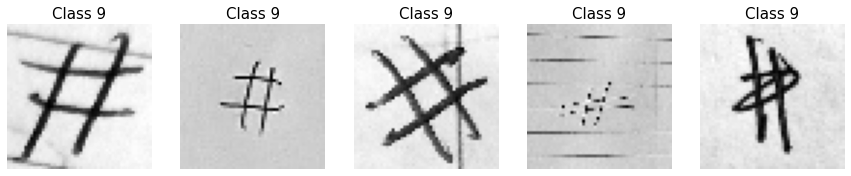

In [4]:
# Displaying some random examples per class

for i in range(0,10):
    rnd_sample = npr.permutation(np.where(t_train==i)[0])
    fig=plt.figure(figsize=(15,3))
    for j in range(5):
        fig.add_subplot(1,5,j+1)
        plt.imshow(X_train_reshaped[rnd_sample[j],:].reshape((50,50)),cmap='gray')
        plt.axis('off');plt.title('Class '+str(int(t_train[rnd_sample[j]])),size=15)
    plt.show()
    print('\n\n')

## Question 1: Implement Recursive Feature Elimination (RFE) to select the subset of features. Experiment with at least 2 different estimators. 


In [5]:
# RFE with logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
import warnings
warnings.filterwarnings("ignore")

lr = LogisticRegression()

t0 = time()
rfe_lr = Pipeline([('scaler', MinMaxScaler()),
                ('RFE', RFE(estimator=lr, step=10))])
rfe_lr.fit(X_train_reshaped, t_train)
t1 = time()

print('The time used for feature selection of RFE with logistic regression: {:.2f}'.format(t1-t0))
print('The accuracy of RFE with logistic regression:', rfe_lr.score(X_train_reshaped, t_train))

The time used for feature selection of RFE with logistic regression: 929.04
The accuracy of RFE with logistic regression: 0.5398809523809524


In [6]:
# RFE with SVM
from sklearn.svm import SVC

svm = SVC(kernel='linear', class_weight='balanced', max_iter=100)

t0 = time()
rfe_svm = Pipeline([('scaler', MinMaxScaler()),
                ('RFE', RFE(estimator=svm, step=10))])
rfe_svm.fit(X_train_reshaped, t_train)
t1 = time()

print('The time used for feature selection of RFE with logistic regression: {:.2f}'.format(t1-t0))
print('The accuracy of RFE with logistic regression:', rfe_svm.score(X_train_reshaped, t_train))

The time used for feature selection of RFE with logistic regression: 1481.52
The accuracy of RFE with logistic regression: 0.24717261904761906


In [7]:
import joblib

joblib.dump(rfe_lr, 'Model/rfe_lr_question1.pkl')
joblib.dump(rfe_svm, 'Model/rfe_svm_question1.pkl')

['Model/rfe_svm_question1.pkl']

## Question 2: Implement Principal Component Analysis (PCA) to select the number of components that explain at least 90% of the explained variance. Train a classifier on the original dataset and the reduced dataset.

In order to select the number of components that explain at least 90% of the explained variance, we need to pick 182 components


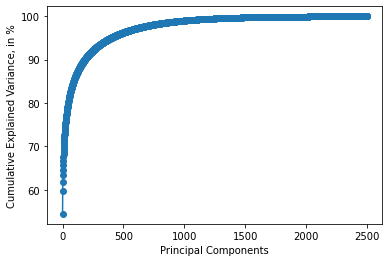

In [8]:
from sklearn.decomposition import PCA

pca = Pipeline([('scaler', MinMaxScaler()),
               ('PCA', PCA(n_components=2500))])

pca.fit(X_train_reshaped)

num_to_choose = np.where(np.cumsum(pca.named_steps['PCA'].explained_variance_ratio_)>0.9)[0][0]

print('In order to select the number of components that explain at least 90% of the explained variance, we', 
      'need to pick {} components'.format(num_to_choose))

plt.plot(100*np.cumsum(pca.named_steps['PCA'].explained_variance_ratio_), '-o')
plt.xlabel('Principal Components',size=10)
plt.ylabel('Cumulative Explained Variance, in %', size=10);

In [9]:
# SVM classifier with PCA
svm_pca = Pipeline([('scaler', MinMaxScaler()),
                   ('PCA', PCA(n_components=num_to_choose)),
                   ('SVM', SVC(kernel='rbf', class_weight='balanced'))])

t0 = time()
svm_pca.fit(X_train_reshaped, t_train)
t1 = time()
t_svm_pca = t1 - t0

print('The time used in training of SVM with PCA is {:.2f} sec.'.format(t_svm_pca))

The time used in training of SVM with PCA is 10.12 sec.


In [10]:
# SVM classifier without PCA

svm = Pipeline([('scaler', MinMaxScaler()),
                ('SVM', SVC(kernel='rbf', class_weight='balanced'))])

t0 = time()
svm.fit(X_train_reshaped, t_train)
t1 = time()
t_svm = t1 - t0

print('The time used in training of SVM without PCA is {:.2f} sec.'.format(t_svm))

The time used in training of SVM without PCA is 104.32 sec.


In [11]:
# Load the model
joblib.dump(svm_pca, 'Model/svm_pca_question2.pkl')
joblib.dump(svm, 'Model/svm_question2.pkl')

['Model/svm_question2.pkl']

## Question 3: Use Fisher's Linear Discriminant Analysis (LDA) and t-SNE to reduce the dataset to 2-dimensions and visualize it.

In [12]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pipe = Pipeline([('scaler', MinMaxScaler()),
                ('features_selector', LDA(n_components=2))])

model = pipe.fit(X_train_reshaped, t_train)
X_train_lda = pipe.fit_transform(X_train_reshaped, t_train)

joblib.dump(model, 'Model/lda_question3.pkl')
np.save('Dataset/data_train_lda_question3.npy', arr=X_train_lda)

In [13]:
# t_SNE
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA

pipe = Pipeline([('scaler', MinMaxScaler()),
                ('features_selector', TSNE(n_components=2))])

model = pipe.fit(X_train_reshaped, t_train)
X_train_tsne = pipe.fit_transform(X_train_reshaped, t_train)

joblib.dump(model, 'Model/tsne_question3.pkl')
np.save('Dataset/data_train_tsne_question3.npy', arr=X_train_tsne)

# PCA
pipe = Pipeline([('scaler', MinMaxScaler()),
                ('features_selector', PCA(n_components=2))])

model = pipe.fit(X_train_reshaped, t_train)
X_train_pca = pipe.fit_transform(X_train_reshaped, t_train)

joblib.dump(model, 'Model/pca_question3.pkl')
np.save('Dataset/data_train_pca_question3.npy', arr=X_train_pca)

## Question 4: Implement at least 3 manifold learning algorithms for reducing the dimensionality of the feature space. Utilize the new lower-dimensional feature space to build a classifier.

In [14]:
from sklearn.manifold import MDS, Isomap
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

# MDS
class Custom_MDS(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.mds = MDS(n_components=self.n_components)
    
    def fit(self, X, y=None):
        self.mds.fit_transform(X, y)
        return self
    
    def transform(self, X, y=None):
        self.embedding_ = self.mds.fit_transform(X,y)
        return self.embedding_
    
    def fit_transform(self, X, y=None):
        self.mds.fit_transform(X, y)
        self.embedding_ = self.mds.fit_transform(X,y)
        return self.embedding_
    
svm_mds = Pipeline([('scaler', MinMaxScaler()),
                   ('features_selector', Custom_MDS()),
                   ('classifier', SVC(kernel='rbf', class_weight='balanced'))])

svm_mds.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('features_selector', Custom_MDS()),
  ('classifier', SVC(class_weight='balanced'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'features_selector': Custom_MDS(),
 'classifier': SVC(class_weight='balanced'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'features_selector__n_components': 2,
 'classifier__C': 1.0,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': 'balanced',
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'rbf',
 'classifier__max_iter': -1,
 'classifier__probability': False,
 'classifier__random_state': None,
 'classifier__shrinking': True,
 'classifier__tol': 0.001,
 'classifier__verbose': False}

In [15]:
params_grid = {'features_selector__n_components': np.arange(50, 71, 5)}
mds_grid = GridSearchCV(estimator=svm_mds,
                       param_grid=params_grid,
                       cv=5,
                       refit=True)

In [16]:
t0 = time()

mds_grid.fit(X_train_reshaped, t_train)

t1 = time()
print('Time used:', t1-t0)

Time used: 32885.88307094574


In [17]:
mds_grid.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('features_selector', Custom_MDS(n_components=60)),
                ('classifier', SVC(class_weight='balanced'))])

In [18]:
# Isomap
svm_isomap = Pipeline([('scaler', MinMaxScaler()),
                   ('features_selector', Isomap()),
                   ('classifier', SVC(kernel='rbf', class_weight='balanced'))])

svm_isomap.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('features_selector', Isomap()),
  ('classifier', SVC(class_weight='balanced'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'features_selector': Isomap(),
 'classifier': SVC(class_weight='balanced'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'features_selector__eigen_solver': 'auto',
 'features_selector__max_iter': None,
 'features_selector__metric': 'minkowski',
 'features_selector__metric_params': None,
 'features_selector__n_components': 2,
 'features_selector__n_jobs': None,
 'features_selector__n_neighbors': 5,
 'features_selector__neighbors_algorithm': 'auto',
 'features_selector__p': 2,
 'features_selector__path_method': 'auto',
 'features_selector__radius': None,
 'features_selector__tol': 0,
 'classifier__C': 1.0,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': 'balanced',
 'classifier__coef0': 0.0,
 'classifier__decision_functio

In [19]:
params_grid = {'features_selector__n_components': np.arange(50, 81, 5)}
isomap_grid = GridSearchCV(estimator=svm_isomap,
                       param_grid=params_grid,
                       cv=5,
                       refit=True)


In [20]:
t0 = time()

isomap_grid.fit(X_train_reshaped, t_train)

t1 = time()
print('Time used:', t1-t0)

Time used: 1305.5829355716705


In [21]:
isomap_grid.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('features_selector', Isomap(n_components=80)),
                ('classifier', SVC(class_weight='balanced'))])

In [22]:
# LLE
svm_lle = Pipeline([('scaler', MinMaxScaler()),
                   ('features_selector', LLE()),
                   ('classifier', SVC(kernel='rbf', class_weight='balanced'))])

svm_lle.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('features_selector', LocallyLinearEmbedding()),
  ('classifier', SVC(class_weight='balanced'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'features_selector': LocallyLinearEmbedding(),
 'classifier': SVC(class_weight='balanced'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'features_selector__eigen_solver': 'auto',
 'features_selector__hessian_tol': 0.0001,
 'features_selector__max_iter': 100,
 'features_selector__method': 'standard',
 'features_selector__modified_tol': 1e-12,
 'features_selector__n_components': 2,
 'features_selector__n_jobs': None,
 'features_selector__n_neighbors': 5,
 'features_selector__neighbors_algorithm': 'auto',
 'features_selector__random_state': None,
 'features_selector__reg': 0.001,
 'features_selector__tol': 1e-06,
 'classifier__C': 1.0,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': 'balanced',
 'classifie

In [23]:
params_grid = {'features_selector__n_components': np.arange(50, 81, 5)}
lle_grid = GridSearchCV(estimator=svm_lle,
                       param_grid=params_grid,
                       cv=5,
                       refit=True)


In [24]:
t0 = time()

lle_grid.fit(X_train_reshaped, t_train)

t1 = time()
print('Time used:', t1-t0)

Time used: 791.2627699375153


In [25]:
lle_grid.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('features_selector', LocallyLinearEmbedding(n_components=75)),
                ('classifier', SVC(class_weight='balanced'))])

In [26]:
joblib.dump(isomap_grid.best_estimator_, 'Model/svm_isomap_question4.pkl')
joblib.dump(lle_grid.best_estimator_, 'Model/svm_lle_question4.pkl')
joblib.dump(mds_grid.best_estimator_, 'Model/svm_mds_question4.pkl')

['Model/svm_msd_question4.pkl']